# Gaussian Process

## Kernel function or covariances function

### Squared exponential kernel

In [42]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
def kernel(x):
    return np.exp(-x**2)

Text(0.5, 1.0, 'Squared exponential kernel')

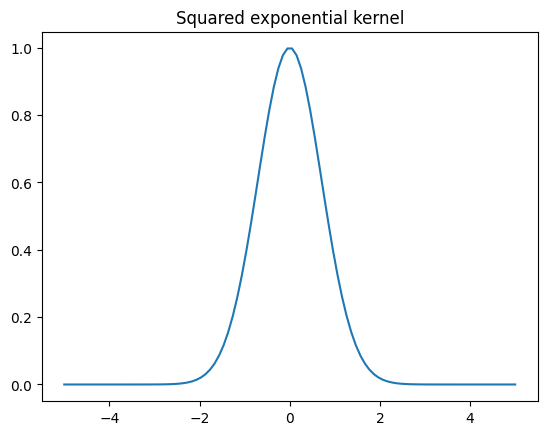

In [44]:
X = np.linspace(-5, 5, 100).reshape(-1, 1)
K = kernel(X)
plt.plot(X, K)
plt.title("Squared exponential kernel")

## Drawing from Gaussian Process Prior

In [45]:
np.random.seed(8)

In [46]:
n = 100 
X_test = np.linspace(-5, 5, n).reshape(-1, 1)
X_test.shape

(100, 1)

Kernel funtion: squared exponential distance between two locations

In [47]:
def kernel(a, b):
    sq_distance = np.sum(a**2, 1).reshape(-1, 1) + np.sum(b**2, 1) - 2*np.dot(a, b.T)
    return np.exp(-sq_distance)

In [48]:
np.eye(n)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [49]:
K

array([[1.38879439e-11],
       [3.77474939e-11],
       [1.00525455e-10],
       [2.62302071e-10],
       [6.70602464e-10],
       [1.67983382e-09],
       [4.12292325e-09],
       [9.91475372e-09],
       [2.33612654e-08],
       [5.39322510e-08],
       [1.21994003e-07],
       [2.70374774e-07],
       [5.87126398e-07],
       [1.24920812e-06],
       [2.60420842e-06],
       [5.31929936e-06],
       [1.06456180e-05],
       [2.08749322e-05],
       [4.01067085e-05],
       [7.54999601e-05],
       [1.39256082e-04],
       [2.51663004e-04],
       [4.45617596e-04],
       [7.73113109e-04],
       [1.31420010e-03],
       [2.18885859e-03],
       [3.57200177e-03],
       [5.71141054e-03],
       [8.94772943e-03],
       [1.37347279e-02],
       [2.06568943e-02],
       [3.04402171e-02],
       [4.39509449e-02],
       [6.21765240e-02],
       [8.61831599e-02],
       [1.17045882e-01],
       [1.55749843e-01],
       [2.03065828e-01],
       [2.59408275e-01],
       [3.24689734e-01],


In [50]:
K + 1e-10*np.eye(n)

array([[1.13887944e-10, 1.38879439e-11, 1.38879439e-11, ...,
        1.38879439e-11, 1.38879439e-11, 1.38879439e-11],
       [3.77474939e-11, 1.37747494e-10, 3.77474939e-11, ...,
        3.77474939e-11, 3.77474939e-11, 3.77474939e-11],
       [1.00525455e-10, 1.00525455e-10, 2.00525455e-10, ...,
        1.00525455e-10, 1.00525455e-10, 1.00525455e-10],
       ...,
       [1.00525455e-10, 1.00525455e-10, 1.00525455e-10, ...,
        2.00525455e-10, 1.00525455e-10, 1.00525455e-10],
       [3.77474939e-11, 3.77474939e-11, 3.77474939e-11, ...,
        3.77474939e-11, 1.37747494e-10, 3.77474939e-11],
       [1.38879439e-11, 1.38879439e-11, 1.38879439e-11, ...,
        1.38879439e-11, 1.38879439e-11, 1.13887944e-10]])

In [51]:
# Calculate the pairwise distance, resulting in a m*x matrix
K = kernel(X_test, X_test)
# Adding a small number along diagonal elements to ensure cholesky
# decomposition works to creare a positive definite matrix
L = np.linalg.cholesky(K + 1e-10*np.eye(n))
L

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.89848834e-01, 1.42124193e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.60009439e-01, 2.78521266e-01, 2.84214945e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.03026390e-42, 8.82107206e-41, 2.65998708e-39, ...,
        1.69296199e-04, 0.00000000e+00, 0.00000000e+00],
       [2.77640792e-43, 1.23514614e-41, 3.81396177e-40, ...,
        8.59749800e-04, 1.69296342e-04, 0.00000000e+00],
       [3.72007598e-44, 1.69441711e-42, 5.35728203e-41, ...,
        2.79071149e-03, 8.59749843e-04, 1.69293153e-04]])

In [52]:
# Calculating funtional samples ny multiplying the standard deviatio
# with stardard normal samples
# that is equal to aggregate a factor correlations between the data
samples = np.dot(L, np.random.normal(size=(n, 5)))
samples

array([[ 9.12047166e-02,  1.09128273e+00, -1.94697031e+00,
        -1.38634953e+00, -2.29649157e+00],
       [ 4.32774637e-01,  1.32577226e+00, -1.61388551e+00,
        -1.25931223e+00, -2.13440645e+00],
       [ 7.25112721e-01,  1.58334676e+00, -1.28702069e+00,
        -1.12840512e+00, -1.94345306e+00],
       [ 9.46450968e-01,  1.85303494e+00, -9.86383944e-01,
        -1.00127628e+00, -1.73608918e+00],
       [ 1.08539182e+00,  2.11918787e+00, -7.27655429e-01,
        -8.82969089e-01, -1.52757049e+00],
       [ 1.14140940e+00,  2.36338548e+00, -5.20118729e-01,
        -7.75616100e-01, -1.33441261e+00],
       [ 1.12403224e+00,  2.56686813e+00, -3.65735999e-01,
        -6.78667970e-01, -1.17228417e+00],
       [ 1.05012543e+00,  2.71333966e+00, -2.59844734e-01,
        -5.89798376e-01, -1.05385325e+00],
       [ 9.40338073e-01,  2.79131529e+00, -1.92875385e-01,
        -5.05978883e-01, -9.86873304e-01],
       [ 8.15497216e-01,  2.79614783e+00, -1.52719782e-01,
        -4.25421273e-01

Text(0.5, 1.0, 'Five random samples from a GP prior')

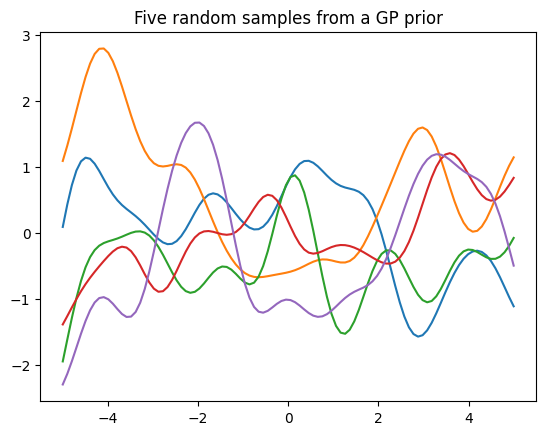

In [53]:
plt.plot(X_test, samples)
plt.title("Five random samples from a GP prior")

Defining the isotropic squared exponential kernel
$$\kappa(x_i, x_j) = \sigma_f^2\exp(-\frac{1}{2l^2}||x_i-x_j||^2)$$

In [55]:
def ise_kernel(X1, X2, l = 1.0, sigma_f = 0.0):
    sq_distance = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2*np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5/(l**2) * sq_distance)

With this formula, we can obtane the mean vector (assumed to be zero) and covariance matrix (using l = 1, $\sigma_f^2 = 1$) based on a list of input locations

In [60]:
# mean and covariance matrix prior
mu = np.zeros(X_test.shape)
K = ise_kernel(X_test, X_test)
K

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])